In [44]:
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [17]:
df = pd.read_excel('Cryotherapy.xlsx')

In [18]:
X, target = df[df.columns[:-1]], df['Result_of_Treatment']

### Заметим, что время сильно кореллирует с результатом лечения, проверим данную гипотезу

In [25]:
df.corr()

,sex,age,Time,Number_of_Warts,Type,Area,Result_of_Treatment
sex,1.000000,-0.115185,0.074417,0.018952,0.219970,0.091213,-0.086203
age,-0.115185,1.000000,0.236305,-0.034797,0.415536,0.080915,-0.542780
Time,0.074417,0.236305,1.000000,-0.074354,0.235056,0.241559,-0.654147
Number_of_Warts,0.018952,-0.034797,-0.074354,1.000000,0.002784,0.108762,0.078273
Type,0.219970,0.415536,0.235056,0.002784,1.000000,0.354398,-0.485030
Area,0.091213,0.080915,0.241559,0.108762,0.354398,1.000000,-0.188886
Result_of_Treatment,-0.086203,-0.542780,-0.654147,0.078273,-0.485030,-0.188886,1.000000


#### Заметим, что время влияет на результат лечения, попробуем проверить это как статистическую гипотезу проверив средние по времени с помощью z-test'а.
#### $H_0:$ средние равны, $H_1:$ средние не равны
#### Уровень доверия, возьмем $\alpha = 0.001$, тогда доверительная область статисики есть: $(-3.29053 ; 3.29053)$.

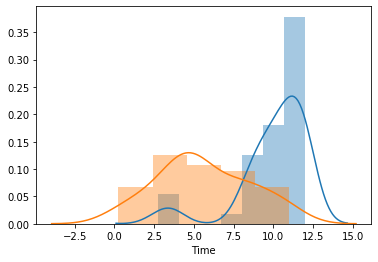

In [12]:
sns.distplot(df[df['Result_of_Treatment'] == 0]['Time'])
sns.distplot(df[df['Result_of_Treatment'] == 1]['Time'])

In [14]:
X_1 = df[df['Result_of_Treatment'] == 0]['Time']
X_2 = df[df['Result_of_Treatment'] == 1]['Time']

#### Видно, что статистика критерия не попадает в доверительную область, есть основания полагать, что время влияет на лечение.

In [15]:
(X_1.mean() - X_2.mean())/(np.sqrt(X_1.std()**2/X_1.count() + X_2.std()**2/X_2.count()))

8.248879771426479

#### Видно так же, что тип бородавок скореллирован с лечением, попробуем выяснить в чем проблема
#### Рассмотрим распределение борадавок по типам и посмотрим в скольких % случаев получился положительный результат

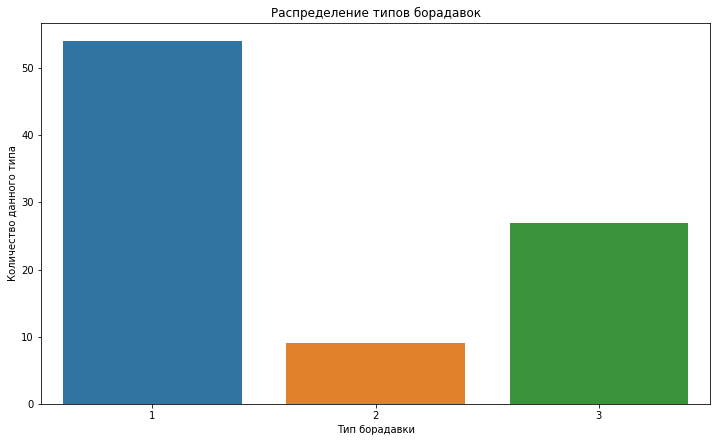

In [47]:
plt.figure(figsize=(12, 7))
g = sns.countplot(df['Type'])
g.set(title='Распределение типов борадавок', xlabel='Тип борадавки', ylabel='Количество данного типа');

#### Видно, что первого и третьего типа имеют существенные различия, второго типа имеют слишком малое количество данных для сравнения.

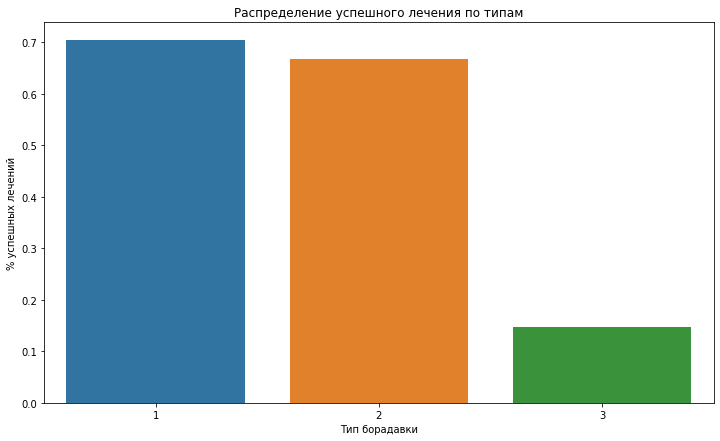

In [50]:
plt.figure(figsize=(12, 7))
g = sns.barplot(x=[1,2,3], y=df.groupby('Type').describe()['Result_of_Treatment']['mean'])
g.set(title='Распределение успешного лечения по типам', xlabel='Тип борадавки', ylabel='% успешных лечений');

#### Проверим, что борадавки третьего типа имеют распределение отличного от первого, для этого построим доверительный интервал для борадавок первого типа и третьего типа и посмотрим имеют ли они пересечение.
#### Так как в моем предположении распределение успеха лечения имеет распределение Бернулли, то будем строить доверительный интервал для него. 
Будем строить доверительный интервал для каждого типа с уровнем доверия $\alpha = 0.001$.

In [95]:
def get_confidience(data):
    z, n, p = 3.29053, len(data), sum(data) / len(data)
    return (max(0, p - z * (p * (1-p)/n) ** 0.5), min(1, p + z * (p * (1-p)/n) ** 0.5))

In [96]:
X_1 = df[df['Type'] == 1]['Result_of_Treatment']
X_2 = df[df['Type'] == 3]['Result_of_Treatment']

#### Видно, что полученные доверительные интервалы не пересекаются, значит нет оснований полагать, что успех от лечения в этих группах распределен одинаковым образом

In [97]:
print('Дверительный интервал для борадавок первого типа:', get_confidience(sample_1))
print('Дверительный интервал для борадавок второго типа:', get_confidience(sample_2))

Дверительный интервал для борадавок первого типа: (0.49923492424451477, 0.9081724831628927)
Дверительный интервал для борадавок второго типа: (0, 0.3731127162110931)
